In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from patsy import dmatrices

# Load Data
data_fpath = "../data/glasgow-litter-simd2020v2.csv"

df = pd.read_csv(data_fpath, header=0)
n_rows = len(df.index)
n_columns = len(df.columns)

# Handle Missing Data
df = df.replace("*", np.NaN)
df = df.fillna(0)

# Handle Incorrect Data Types
to_category_features = ["Data_Zone", "Intermediate_Zone", "Council_area"]
for feature in to_category_features:
  df[feature] = df[feature].astype("category")

to_float_features = [
  "income_rate",
  "employment_rate",
  "crime_rate",
  "DEPRESS",
  "LBWT",
  "Attendance",
  "not_participating",
  "University",
  "overcrowded_rate",
  "nocentralheating_rate",
  "broadband",
  "crime_count",
  "Attainment"
]
for feature in to_float_features:
  df[feature] = df[feature].str.rstrip("%").astype(float) / 100

# Split Data
df_train, df_valid, df_test = np.split(df.sample(frac=1, random_state=1), [int(.7*len(df)), int(.9*len(df))])

In [8]:
formula = "litter ~ Total_population + Working_Age_population + income_rate + income_count + employment_rate + employment_count + CIF + ALCOHOL + DRUG + SMR + DEPRESS + LBWT + EMERG + Attendance + Attainment + no_qualifications + not_participating + University + crime_count + crime_rate + overcrowded_rate + nocentralheating_rate + drive_petrol + drive_GP + drive_post + drive_primary + drive_retail + drive_secondary + PT_GP + PT_post + PT_retail + broadband"
y_train, X_train = dmatrices(formula, df_train, return_type="dataframe")
y_valid, X_valid = dmatrices(formula, df_valid, return_type="dataframe")

model = sm.OLS(y_train, X_train)
model = model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 litter   R-squared:                       0.340
Model:                            OLS   Adj. R-squared:                  0.290
Method:                 Least Squares   F-statistic:                     6.776
Date:                Mon, 03 Jan 2022   Prob (F-statistic):           1.07e-22
Time:                        15:31:52   Log-Likelihood:                -2072.8
No. Observations:                 454   AIC:                             4212.
Df Residuals:                     421   BIC:                             4348.
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 81.3029     29.304      2.774      0.006      23.703     138.903
Total_population          -0.0226      0.032     -0.704      0.482      -0.086       0.041
Working_Age_population     0.0157      0.033      0.483      0.630      -0.048       0.080
income_rate               40.0079    109.283      0.366      0.714    -174.800     254.815
income_count               0.1513      0.129      1.175      0.241      -0.102       0.404
employment_rate          213.4772    119.597      1.785      0.075     -21.604     448.559
employment_count          -0.4445      0.208     -2.135      0.033      -0.854      -0.035
CIF                       -0.1087      0.074     -1.468      0.143      -0.254       0.037
ALCOHOL                    0.0065      0.016      0.412      0.681      -0.025       0.038
DRUG                      -0.0052      0.011     -0.475      0.635      -0.027       0.016
SMR                        0.0225      0.025      0.884      0.377      -0.028       0.073
DEPRESS                  -44.9014     43.493     -1.032      0.302    -130.392      40.589
LBWT                      37.3845     27.099      1.380      0.168     -15.881      90.650
EMERG                     -0.0113      0.068     -0.166      0.868      -0.145       0.122
Attendance               -35.0619     21.951     -1.597      0.111     -78.209       8.085
Attainment               322.2611    359.853      0.896      0.371    -385.071    1029.593
no_qualifications          0.0247      0.048      0.520      0.603      -0.069       0.118
not_participating          6.9775     42.645      0.164      0.870     -76.845      90.800
University                -9.7243     30.534     -0.318      0.750     -69.743      50.294
crime_count               33.2858     22.155      1.502      0.134     -10.263      76.834
crime_rate                -3.3074      1.869     -1.770      0.077      -6.981       0.366
overcrowded_rate          47.4488     22.674      2.093      0.037       2.879      92.018
nocentralheating_rate    -27.2830     51.092     -0.534      0.594    -127.710      73.144
drive_petrol              -4.2734      1.186     -3.605      0.000      -6.604      -1.943
drive_GP                   1.0159      2.711      0.375      0.708      -4.312       6.344
drive_post                -2.1368      2.882     -0.741      0.459      -7.802       3.528
drive_primary             -0.4859      1.626     -0.299      0.765      -3.681       2.709
drive_retail               0.8446      1.732      0.488      0.626      -2.560       4.249
drive_secondary            1.5379      0.919      1.674      0.095      -0.268       3.344
PT_GP                     -0.1637      0.957     -0.171      0.864      -2.044       1.717
PT_post                   -0.5318      0.967     -0.550      0.583      -2.433  

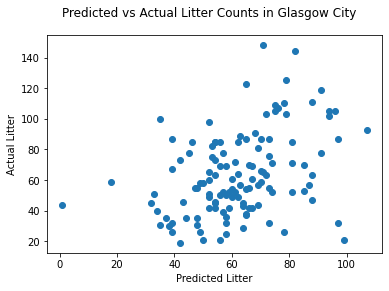

In [9]:
predictions = model.get_prediction(X_valid)
df_predictions = predictions.summary_frame()
predicted_counts, actual_counts = round(df_predictions["mean"]), y_valid["litter"]

fig = plt.figure()
fig.suptitle("Predicted vs Actual Litter Counts in Glasgow City")
plt.scatter(x=predicted_counts, y=actual_counts)
plt.xlabel("Predicted Litter")
plt.ylabel("Actual Litter")
plt.show()

In [14]:
import statsmodels.formula.api as smf

def forward_selected(data, response):
    """Linear model designed by forward selection.

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response

    response: string, name of response column in data

    Returns:
    --------
    model: an "optimal" fitted statsmodels linear model
           with an intercept
           selected by forward selection
           evaluated by adjusted R-squared
    """
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    current_score, best_new_score = 0.0, 0.0
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {} + 1".format(response,
                                           ' + '.join(selected + [candidate]))
            score = smf.ols(formula, data).fit().rsquared_adj
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        if current_score < best_new_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
    formula = "{} ~ {} + 1".format(response,
                                   ' + '.join(selected))
    model = smf.ols(formula, data).fit()
    return model

model = forward_selected(df_train, "litter")
model.summary()

c:\Users\Gary Blackwood\dev\glasgow-litter\venv\lib\site-packages\statsmodels\regression\linear_model.py:1751: RuntimeWarning: divide by zero encountered in true_divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
c:\Users\Gary Blackwood\dev\glasgow-litter\venv\lib\site-packages\statsmodels\regression\linear_model.py:1751: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 litter   R-squared:                       0.347
Model:                            OLS   Adj. R-squared:                  0.337
Method:                 Least Squares   F-statistic:                     36.88
Date:                Mon, 03 Jan 2022   Prob (F-statistic):           2.24e-41
Time:                        16:36:34   Log-Likelihood:                -2251.9
No. Observations:                 494   AIC:                             4520.
Df Residuals:                     486   BIC:                             4554.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                         29.4708     18.961      1.554      0.121      -7.784      66.726
income_rate                      182.4838     32.371      5.637      0.000     118.880     246.088
drive_petrol                      -3.8433      0.947     -4.058      0.000      -5.704      -1.982
overcrowded_rate                  48.1438     15.245      3.158      0.002      18.189      78.099
employment_count                  -0.1273      0.039     -3.277      0.001      -0.204      -0.051
Attainment                       728.4898    372.573      1.955      0.051      -3.563    1460.543
SIMD2020_Education_Domain_Rank    -0.0046      0.001     -3.099      0.002      -0.007      -0.002
CIF                               -0.1388      0.056     -2.484      0.013      -0.249      -0.029
==============================================================================
Omnibus:                       56.841   Durbin-Watson:                   1.965
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               89.235
Skew:                           0.755   Prob(JB):                     4.20e-20
Kurtosis:                       4.434   Cond. No.                     1.13e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.13e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

0      61.0
1      87.0
2      57.0
3      46.0
4      57.0
       ... 
131    71.0
132    32.0
133    78.0
134    52.0
135    78.0
Name: mean, Length: 136, dtype: float64 326     55.0
458    144.0
465     64.0
167     60.0
145     50.0
       ...  
87      87.0
655     41.0
678    107.0
418     58.0
288     71.0
Name: litter, Length: 136, dtype: float64


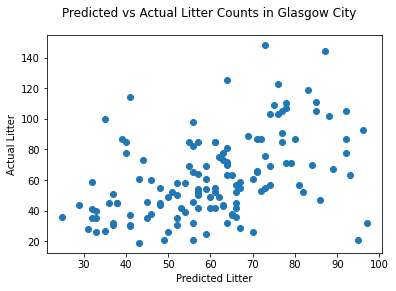

In [15]:

y_train, X_train = dmatrices(model.model.formula, df_train, return_type="dataframe")
y_valid, X_valid = dmatrices(model.model.formula, df_valid, return_type="dataframe")

predictions = model.get_prediction(X_valid)
df_predictions = predictions.summary_frame()
predicted_counts, actual_counts = round(df_predictions["mean"]), y_valid["litter"]
print(predicted_counts, actual_counts)

fig = plt.figure()
fig.suptitle("Predicted vs Actual Litter Counts in Glasgow City")
plt.scatter(x=predicted_counts, y=actual_counts)
plt.xlabel("Predicted Litter")
plt.ylabel("Actual Litter")
plt.show()